In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
import gc
sys.path.append('/content/drive/MyDrive/Colab Notebooks/1_Papers/3_Attack_generation')
from utils.utils import setup_logging, get_config_from_yaml, process_config, print_config
from dataset.cityscapes import Cityscapes
from metrics.performance import SegmentationMetric
from utils.helper import val_plot
from patch.create import Patch
#from metrics.performance import SegmentationMetric


from pretrained_models.ICNet.icnet import ICNet
from pretrained_models.BisNetV1.model import BiSeNetV1
from pretrained_models.BisNetV2.model import BiSeNetV2
from pretrained_models.PIDNet.model import PIDNet, get_pred_model
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
import pickle
from copy import deepcopy
# from trainer.trainer import Trainer
# import torch
from tqdm import tqdm
config = get_config_from_yaml('/content/drive/MyDrive/Colab Notebooks/1_Papers/3_Attack_generation/configs/config.yaml')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Things to do:
1. Table1:
  - MIOU of all models with random patch on the validation set
2. Table2:
  - Rows: Patches from different models (7 models)
  - Columns: MIOU Evaluated on different models (7 models)
3. Bar plot:
  - 7 bar plots corresponding to 7 patches showing how much performance dropped for each model  

  

# Getting patches

In [2]:
pidnet_l_p = pickle.load(open( "/content/drive/MyDrive/Colab Notebooks/1_Papers/3_Attack_generation/Experiments/pidnet_l.p", "rb" ))[0]
pidnet_m_p = pickle.load(open( "/content/drive/MyDrive/Colab Notebooks/1_Papers/3_Attack_generation/Experiments/pidnet_m.p", "rb" ))[0]
pidnet_s_p = pickle.load(open( "/content/drive/MyDrive/Colab Notebooks/1_Papers/3_Attack_generation/Experiments/pidnet_s.p", "rb" ))[0]
icnet_p = pickle.load(open( "/content/drive/MyDrive/Colab Notebooks/1_Papers/3_Attack_generation/Experiments/icnet.p", "rb" ))[0]
bisenetv1_p = pickle.load(open( "/content/drive/MyDrive/Colab Notebooks/1_Papers/3_Attack_generation/Experiments/bisenet_v1.p", "rb" ))[0]
bisenetv2_p = pickle.load(open( "/content/drive/MyDrive/Colab Notebooks/1_Papers/3_Attack_generation/Experiments/bisenet_v2.p", "rb" ))[0]
segformer_p = pickle.load(open( "/content/drive/MyDrive/Colab Notebooks/1_Papers/3_Attack_generation/Experiments/segformer.p", "rb" )).detach()
patches = {
    'pidnet_l':pidnet_l_p,
    'pidnet_m':pidnet_m_p,
    'pidnet_s':pidnet_s_p,
    'icnet':icnet_p,
    'bisenetv1':bisenetv1_p,
    'bisenetv2':bisenetv2_p,
    'segformer':segformer_p
}

for patch in patches:
  patches[patch] = patches[patch].to(device)
  print(patch)


pidnet_l
pidnet_m
pidnet_s
icnet
bisenetv1
bisenetv2
segformer


In [3]:
torch.rand(2,2)

tensor([[0.1564, 0.1620],
        [0.9764, 0.0853]])

# Getting **data**

In [3]:
cityscape_val = Cityscapes(
          root = config.dataset.root,
          list_path = config.dataset.val,
          num_classes = config.dataset.num_classes,
          multi_scale = False,
          flip = False,
          ignore_label = config.train.ignore_label,
          base_size = config.train.base_size,
          crop_size = (config.train.height,config.train.width),
        )

val_dataloader = torch.utils.data.DataLoader(dataset=cityscape_val,
                                            batch_size=1,
                                            shuffle=True,
                                            num_workers=config.train.num_workers,
                                            pin_memory=config.train.pin_memory,
                                            drop_last=config.train.drop_last)

# Getting all models

In [4]:
## PIDNet-s
model = torch.load('/content/drive/MyDrive/Colab Notebooks/1_Papers/3_Attack_generation/pretrained_models/PIDNet/PIDNet_S_Cityscapes_test.pt',map_location=device)
pidnet_s = get_pred_model(name = 'pidnet_s', num_classes = 19).to(device)
if 'state_dict' in model:
    model = model['state_dict']
model_dict = pidnet_s.state_dict()
model = {k[6:]: v for k, v in model.items() # k[6:] to start after model. in key names
                    if k[6:] in model_dict.keys()}

pidnet_s.load_state_dict(model)
pidnet_s.eval()
print('PIDNet Model loaded')

## PIDNet-m
model = torch.load('/content/drive/MyDrive/Colab Notebooks/1_Papers/3_Attack_generation/pretrained_models/PIDNet/PIDNet_M_Cityscapes_test.pt',map_location=device)
pidnet_m = get_pred_model(name = 'pidnet_m', num_classes = 19).to(device)
if 'state_dict' in model:
    model = model['state_dict']
model_dict = pidnet_m.state_dict()
model = {k[6:]: v for k, v in model.items() # k[6:] to start after model. in key names
                    if k[6:] in model_dict.keys()}

pidnet_m.load_state_dict(model)
pidnet_m.eval()
print('PIDNet Model loaded')


## PIDnet-L
model = torch.load('/content/drive/MyDrive/Colab Notebooks/1_Papers/3_Attack_generation/pretrained_models/PIDNet/PIDNet_L_Cityscapes_test.pt',map_location=device)
pidnet_l = get_pred_model(name = 'pidnet_l', num_classes = 19).to(device)
if 'state_dict' in model:
    model = model['state_dict']
model_dict = pidnet_l.state_dict()
model = {k[6:]: v for k, v in model.items() # k[6:] to start after model. in key names
                    if k[6:] in model_dict.keys()}

pidnet_l.load_state_dict(model)
pidnet_l.eval()
print('PIDNet Model loaded')



## ICNet
model = torch.load('/content/drive/MyDrive/Colab Notebooks/1_Papers/3_Attack_generation/pretrained_models/ICNet/Copy of resnet50_2024-12-22 08:52:50 EST-0500_176_0.661.pth.tar',map_location=device)
icnet = ICNet(nclass = 19).to(device)
icnet.load_state_dict(model['model_state_dict'])
icnet.eval()
print('ICNet loaded')



## BiseNetV1
model = torch.load('/content/drive/MyDrive/Colab Notebooks/1_Papers/3_Attack_generation/pretrained_models/BisNetV1/bisnetv1.pth',map_location=device)
bisenetv1 = BiSeNetV1(19,aux_mode = 'eval').to(device)
bisenetv1.load_state_dict(model, strict=False)
bisenetv1.eval()
print('BisNetV1 loaded')

## BiseNetV2
model = torch.load('/content/drive/MyDrive/Colab Notebooks/1_Papers/3_Attack_generation/pretrained_models/BisNetV2/bisnetv2.pth',map_location=device)
bisenetv2 = BiSeNetV2(19,aux_mode = 'eval').to(device)
bisenetv2.load_state_dict(model, strict=False)
bisenetv2.eval()
print('BisNetV2 loaded')


<ipython-input-4-5c7e0c6efbd3>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/content/drive/MyDrive/Colab Notebooks/1_Papers/3_Attack_generation/pretr

PIDNet Model loaded
PIDNet Model loaded
PIDNet Model loaded


<ipython-input-4-5c7e0c6efbd3>:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/content/drive/MyDrive/Colab Notebooks/1_Papers/3_Attack_generation/pret

ICNet loaded
BisNetV1 loaded
BisNetV2 loaded


<ipython-input-4-5c7e0c6efbd3>:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/content/drive/MyDrive/Colab Notebooks/1_Papers/3_Attack_generation/pret

# Table 1: Random patch

In [8]:
mean_standard = np.array([0.485, 0.456, 0.406],dtype = np.float32)
std_standard = np.array([0.229, 0.224, 0.225],dtype = np.float32)
x = (2048 - 200)//2
y = (1024 - 200)//2
x_end = x + 200
y_end = y + 200
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

metric_pidnet_l = SegmentationMetric(config)
metric_pidnet_m = SegmentationMetric(config)
metric_pidnet_s = SegmentationMetric(config)
metric_icnet = SegmentationMetric(config)
metric_bisenetv1 = SegmentationMetric(config)
metric_bisenetv2 = SegmentationMetric(config)
metric_segformer = SegmentationMetric(config)
metric_pidnet_l.reset()
metric_pidnet_m.reset()
metric_pidnet_s.reset()
metric_icnet.reset()
metric_bisenetv1.reset()
metric_bisenetv2.reset()
metric_segformer.reset()

for iter,batches in tqdm(enumerate(val_dataloader)):
  image_standard,label,_,_,_ = batches
  label_patched = deepcopy(label)

  ## random patch
  patch = torch.rand(3,200,200)
  image_standard[:,:, y:y_end, x:x_end] = patch
  label_patched[:, y:y_end, x:x_end] = config.train.ignore_label
  ## On device
  image_standard = image_standard.to(device)
  label_patched = label_patched.to(device)

  ## PIDNet-l
  outputs = pidnet_l(image_standard)
  size = label.shape
  output = F.interpolate(
                outputs[config.test.output_index_pidnet], size[-2:],
                mode='bilinear', align_corners=True
                        )
  metric_pidnet_l.update(output, label_patched)
  # print(output.shape,label_patched.shape)
  # break

  ##PIDNet-m
  outputs = pidnet_m(image_standard)
  size = label.shape
  output = F.interpolate(
                outputs[config.test.output_index_pidnet], size[-2:],
                mode='bilinear', align_corners=True
                        )
  metric_pidnet_m.update(output, label_patched)

  ## PIDNet-s
  outputs = pidnet_s(image_standard)
  size = label.shape
  output = F.interpolate(
                outputs[config.test.output_index_pidnet], size[-2:],
                mode='bilinear', align_corners=True
                        )
  metric_pidnet_s.update(output, label_patched)

  ##ICNet
  outputs = icnet(image_standard)
  output = outputs[config.test.output_index_icnet]
  metric_icnet.update(output,label_patched)


  ## BisNetV1
  outputs = bisenetv1(image_standard)
  output = outputs[config.test.output_index_bisenet]
  metric_bisenetv1.update(output,label_patched)

  ##BiseNetV2
  outputs = bisenetv2(image_standard)
  output = outputs[config.test.output_index_bisenet]
  metric_bisenetv2.update(output,label_patched)

  ##Segformer
  segformer = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b5-finetuned-cityscapes-1024-1024").to(device)
  segformer.eval()
  outputs = segformer(image_standard)
  del segformer
  output = F.interpolate(
                outputs.logits, size[-2:],
                mode='bilinear', align_corners=True
            )
  metric_segformer.update(output,label_patched)
  del outputs,output,image_standard,label,batches
  gc.collect()
  torch.cuda.empty_cache()



500it [22:01,  2.64s/it]


In [11]:
print(f'PIDNet-L MIOU: {metric_pidnet_l.get()[1]}')
print(f'PIDNet-M MIOU: {metric_pidnet_m.get()[1]}')
print(f'PIDNet-S MIOU: {metric_pidnet_s.get()[1]}')
print(f'ICNet MIOU: {metric_icnet.get()[1]}')
print(f'BisNetV1 MIOU: {metric_bisenetv1.get()[1]}')
print(f'BisNetV2 MIOU: {metric_bisenetv2.get()[1]}')
print(f'Segformer MIOU: {metric_segformer.get()[1]}')

PIDNet-L MIOU: 0.8995722532272339
PIDNet-M MIOU: 0.8618881106376648
PIDNet-S MIOU: 0.8652439117431641
ICNet MIOU: 0.6554849743843079
BisNetV1 MIOU: 0.711010754108429
BisNetV2 MIOU: 0.6844127178192139
Segformer MIOU: 0.8118492960929871


MIOUs with random patch

1. PIDNet-L MIOU: 0.8995722532272339
2. PIDNet-M MIOU: 0.8618881106376648
3. PIDNet-S MIOU: 0.8652439117431641
4. ICNet MIOU: 0.6554849743843079
5. BisNetV1 MIOU: 0.711010754108429
6. BisNetV2 MIOU: 0.6844127178192139
7. Segformer MIOU: 0.8118492960929871

# Table 1: Adversarial patch

In [5]:
mean_standard = np.array([0.485, 0.456, 0.406],dtype = np.float32)
std_standard = np.array([0.229, 0.224, 0.225],dtype = np.float32)
x = (2048 - 200)//2
y = (1024 - 200)//2
x_end = x + 200
y_end = y + 200
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
metric_pidnet_l = SegmentationMetric(config)
metric_pidnet_m = SegmentationMetric(config)
metric_pidnet_s = SegmentationMetric(config)
metric_icnet = SegmentationMetric(config)
metric_bisenetv1 = SegmentationMetric(config)
metric_bisenetv2 = SegmentationMetric(config)
metric_segformer = SegmentationMetric(config)


data = {}
for pat in ['bisenetv1','bisenetv2','segformer']:
  patch = patches[pat]
  metric_pidnet_l.reset()
  metric_pidnet_m.reset()
  metric_pidnet_s.reset()
  metric_icnet.reset()
  metric_bisenetv1.reset()
  metric_bisenetv2.reset()
  metric_segformer.reset()
  print(f'Computing for: {pat}')
  temp = []
  for iter,batches in tqdm(enumerate(val_dataloader)):
    image_standard,label,_,_,_ = batches
    label_patched = deepcopy(label)

    ## adding patch
    image_standard[:,:, y:y_end, x:x_end] = patch
    label_patched[:, y:y_end, x:x_end] = config.train.ignore_label
    ## On device
    image_standard = image_standard.to(device)
    label_patched = label_patched.to(device)

    ## PIDNet-l
    outputs = pidnet_l(image_standard)
    size = label.shape
    output = F.interpolate(
                  outputs[config.test.output_index_pidnet], size[-2:],
                  mode='bilinear', align_corners=True
                          )
    metric_pidnet_l.update(output, label_patched)
    # print(output.shape,label_patched.shape)
    # break

    ##PIDNet-m
    outputs = pidnet_m(image_standard)
    size = label.shape
    output = F.interpolate(
                  outputs[config.test.output_index_pidnet], size[-2:],
                  mode='bilinear', align_corners=True
                          )
    metric_pidnet_m.update(output, label_patched)

    ## PIDNet-s
    outputs = pidnet_s(image_standard)
    size = label.shape
    output = F.interpolate(
                  outputs[config.test.output_index_pidnet], size[-2:],
                  mode='bilinear', align_corners=True
                          )
    metric_pidnet_s.update(output, label_patched)

    ##ICNet
    outputs = icnet(image_standard)
    output = outputs[config.test.output_index_icnet]
    metric_icnet.update(output,label_patched)


    ## BisNetV1
    outputs = bisenetv1(image_standard)
    output = outputs[config.test.output_index_bisenet]
    metric_bisenetv1.update(output,label_patched)

    ##BiseNetV2
    outputs = bisenetv2(image_standard)
    output = outputs[config.test.output_index_bisenet]
    metric_bisenetv2.update(output,label_patched)

    ##Segformer
    segformer = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b5-finetuned-cityscapes-1024-1024").to(device)
    segformer.eval()
    outputs = segformer(image_standard)
    del segformer
    output = F.interpolate(
                  outputs.logits, size[-2:],
                  mode='bilinear', align_corners=True
              )
    metric_segformer.update(output,label_patched)
    del outputs,output,image_standard,label,batches
    gc.collect()
    torch.cuda.empty_cache()

  data[pat] = [
      metric_pidnet_l.get()[1],
      metric_pidnet_m.get()[1],
      metric_pidnet_s.get()[1],
      metric_icnet.get()[1],
      metric_bisenetv1.get()[1],
      metric_bisenetv2.get()[1],
      metric_segformer.get()[1]
  ]
  print(data[pat])


Computing for: bisenetv1


0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
500it [19:44,  2.37s/it]

[0.8994328379631042, 0.8613391518592834, 0.864219069480896, 0.6553126573562622, 0.6504902839660645, 0.6844066977500916, 0.8097118139266968]
Computing for: bisenetv2



500it [16:54,  2.03s/it]

[0.8992447853088379, 0.8615822196006775, 0.8647516369819641, 0.6552879214286804, 0.7117006778717041, 0.29905015230178833, 0.8111395835876465]
Computing for: segformer



500it [16:47,  2.02s/it]

[0.8996761441230774, 0.8623595237731934, 0.8652361631393433, 0.6538180112838745, 0.7134591341018677, 0.685793399810791, 0.44908398389816284]


PIDNet-L patch

[0.7913966774940491, 0.8613004088401794, 0.8632712960243225, 0.6554820537567139, 0.7118179202079773, 0.6848840713500977, 0.8100680112838745]

PIDNet-M patch

[0.898219883441925, 0.7315691709518433, 0.8629072308540344, 0.6548078656196594, 0.7119756937026978, 0.684635579586029, 0.8105466365814209]

PIDNet-S patch

[0.8984268307685852, 0.8615489602088928, 0.7790576815605164, 0.6546480059623718, 0.7119972109794617, 0.684791088104248, 0.8104854822158813]

ICNet Patch

[0.8993214964866638, 0.8616093993186951, 0.8647707104682922, 0.6204441785812378, 0.7115134596824646, 0.6849095821380615, 0.8108776211738586]


BiseNet V1

[0.8994328379631042, 0.8613391518592834, 0.864219069480896, 0.6553126573562622, 0.6504902839660645, 0.6844066977500916, 0.8097118139266968]

BiseNetV2

[0.8992447853088379, 0.8615822196006775, 0.8647516369819641, 0.6552879214286804, 0.7117006778717041, 0.29905015230178833, 0.8111395835876465]


Segformer

[0.8996761441230774, 0.8623595237731934, 0.8652361631393433, 0.6538180112838745, 0.7134591341018677, 0.685793399810791, 0.44908398389816284]



In [2]:
## Putting data together
import numpy as np

table = np.array([
  [0.8995722532272339,0.8618881106376648,0.8652439117431641,0.6554849743843079,0.711010754108429, 0.6844127178192139,0.8118492960929871],
  [0.7913966774940491, 0.8613004088401794, 0.8632712960243225, 0.6554820537567139, 0.7118179202079773, 0.6848840713500977, 0.8100680112838745],
  [0.898219883441925, 0.7315691709518433, 0.8629072308540344, 0.6548078656196594, 0.7119756937026978, 0.684635579586029, 0.8105466365814209],
  [0.8984268307685852, 0.8615489602088928, 0.7790576815605164, 0.6546480059623718, 0.7119972109794617, 0.684791088104248, 0.8104854822158813],
  [0.8993214964866638, 0.8616093993186951, 0.8647707104682922, 0.6204441785812378, 0.7115134596824646, 0.6849095821380615, 0.8108776211738586],
  [0.8994328379631042, 0.8613391518592834, 0.864219069480896, 0.6553126573562622, 0.6504902839660645, 0.6844066977500916, 0.8097118139266968],
  [0.8992447853088379, 0.8615822196006775, 0.8647516369819641, 0.6552879214286804, 0.7117006778717041, 0.29905015230178833, 0.8111395835876465],
  [0.8996761441230774, 0.8623595237731934, 0.8652361631393433, 0.6538180112838745, 0.7134591341018677, 0.685793399810791, 0.44908398389816284]
])


<ipython-input-11-d9abce18afba>:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(model_names, rotation=45, ha='right', size = 11)
<ipython-input-11-d9abce18afba>:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(model_names, rotation=45, ha='right', size = 11)
<ipython-input-11-d9abce18afba>:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(model_names, rotation=45, ha='right', size = 11)
<ipython-input-11-d9abce18afba>:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(model_names, rotation=45, ha='right', size = 11)
<ipython-input-11-d9abce18afba>:15: UserWarn

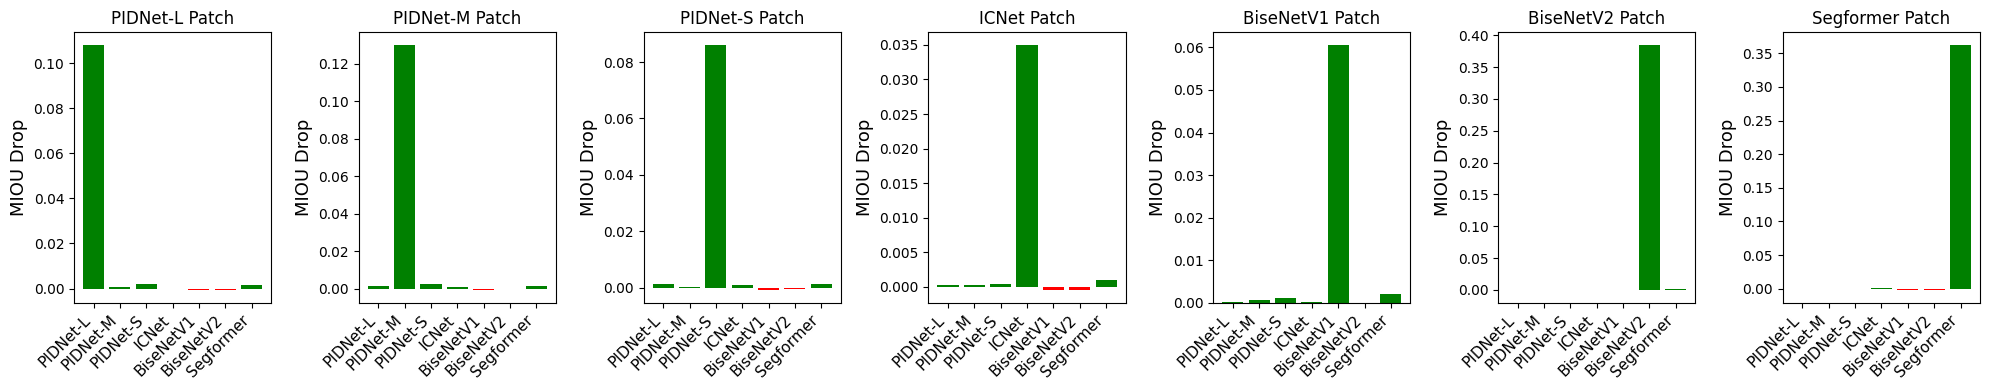

In [11]:
# prompt: change the above plot such that positive bars are green and negative bars are red

import numpy as np
import matplotlib.pyplot as plt

model_names = ['PIDNet-L', 'PIDNet-M', 'PIDNet-S', 'ICNet', 'BiseNetV1', 'BiseNetV2', 'Segformer']

fig, axes = plt.subplots(1, 7, figsize=(20, 4))

for i in range(7):
  diffs = -table[i+1] + table[0]
  colors = ['green' if diff >= 0 else 'red' for diff in diffs]
  axes[i].bar(model_names, diffs, color=colors)
  axes[i].set_title(f'{model_names[i]} Patch')
  axes[i].set_xticklabels(model_names, rotation=45, ha='right', size = 11)
  axes[i].set_ylabel('MIOU Drop',size = 13)


plt.tight_layout()
plt.savefig("/content/drive/MyDrive/Colab Notebooks/1_Papers/3_Attack_generation/Experiments/figure4.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()
